# WATER BAG INCIDENTS IN RIO DE JANEIRO - PRELIMINARY CLUSTERING

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
2. Exploratory Data Analysis
3. Clustering Incidents

### Import modules and functions

In [1]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

### Load data

In [2]:
catalog = pd.read_csv('Dados/water_bag_catalog_google.csv', parse_dates=True, infer_datetime_format=True)

# Extract records of water bag formatioincidents (copy data for cleaning)
catalog = catalog[catalog['POP_TITULO']=="Bolsão d'água em via"].copy()
data = catalog.copy()

---
## 0. Utility functions

#### Functions to format and correct street number text variable

In [3]:
from Modules.text_formatter import text_transform_pipeline, get_not_number, drop_letters, drop_space, drop_chars, split_avg

#### Plot colored and connected coordinates in 2D plane

In [4]:
from Modules.coord_plot import (
    cmaps, filter_group_size,
    cluster_algo_comparison,
    connect_coordinates_colored,
    min_group_size_progression_plot,
    atemporal_evolution_plot,
    min_samples_clusters_animation
)

#### Cluster processing and plot function

---
# 1. Data Cleaning

#### Format and correct street number variable

In [5]:
not_number = get_not_number(catalog['street_number'])
not_number_corrected =  text_transform_pipeline(not_number, [drop_letters, drop_space, drop_chars, split_avg])

data.loc[not_number.index, ['street_number']] = not_number_corrected
data.dropna(subset=['street_number'], inplace=True) # drop rows where street number is missing

#### Data type conversion

In [6]:
float_cols = ['EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'search_lat', 'search_lng', 'street_number']
data[float_cols] = data[float_cols].astype(float)

---
# 2. Cluster Algorithm Comparison

##### Planning:
1. Cluster all points together
2. Cluster by street number
3. Cluster only routes with more than min_incidents
4. Cluster only routes with more than min_incident_density
5. Cluster only routes with number range above min_street_number_range

#### 0.2 Setting automatic clustering algorithms

In [7]:
from sklearn import cluster, mixture
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

mean = cluster.MeanShift(bandwidth=0.01, cluster_all=False, max_iter=1000)
agg = cluster.AgglomerativeClustering(n_clusters=None, linkage='ward', distance_threshold=0.1)
dbscan = cluster.DBSCAN(eps=0.005, min_samples=3)
optics = cluster.OPTICS(max_eps=0.05, min_samples=3)
birch = cluster.Birch(threshold=0.01, branching_factor=5, n_clusters=None)
gaussian = mixture.GaussianMixture(
    n_components=250, covariance_type='full',
    tol=5e-4, reg_covar=1e-6,
    max_iter=500, n_init=1, verbose=1
)
bayesian = mixture.BayesianGaussianMixture(
    n_components=250, weight_concentration_prior=1e-3,
    covariance_type='full',
    tol=5e-4, reg_covar=1e-6,
    max_iter=500, n_init=1, verbose=1)

algs = [mean, agg, dbscan, optics, birch, gaussian, bayesian]

##### Algorithm source code and examples

In [ ]:
a = algs[6]
a?

### 1. Clustering multiple algorithms by geodetic coordinates

##### Fit different algorithms

In [9]:
coords = mms().fit_transform(data[['EVENTO_LONGITUDE', 'EVENTO_LATITUDE']])
unlabeld = ['GaussianMixture', 'BayesianGaussianMixture']

for i, alg in enumerate(algs[:]):
    name = type(alg).__name__
    print(f'{i+1}/{len(algs)} - {name} algorithm running...'); alg.fit(coords); co(wait=True)
    if name in unlabeld:
        alg.labels_ = alg.predict(coords)
print(f'Done! {len(algs)} cluster algorithms fitted.')

Done! 7 cluster algorithms fitted.


### 2. Compare performance of algorithms through visualization

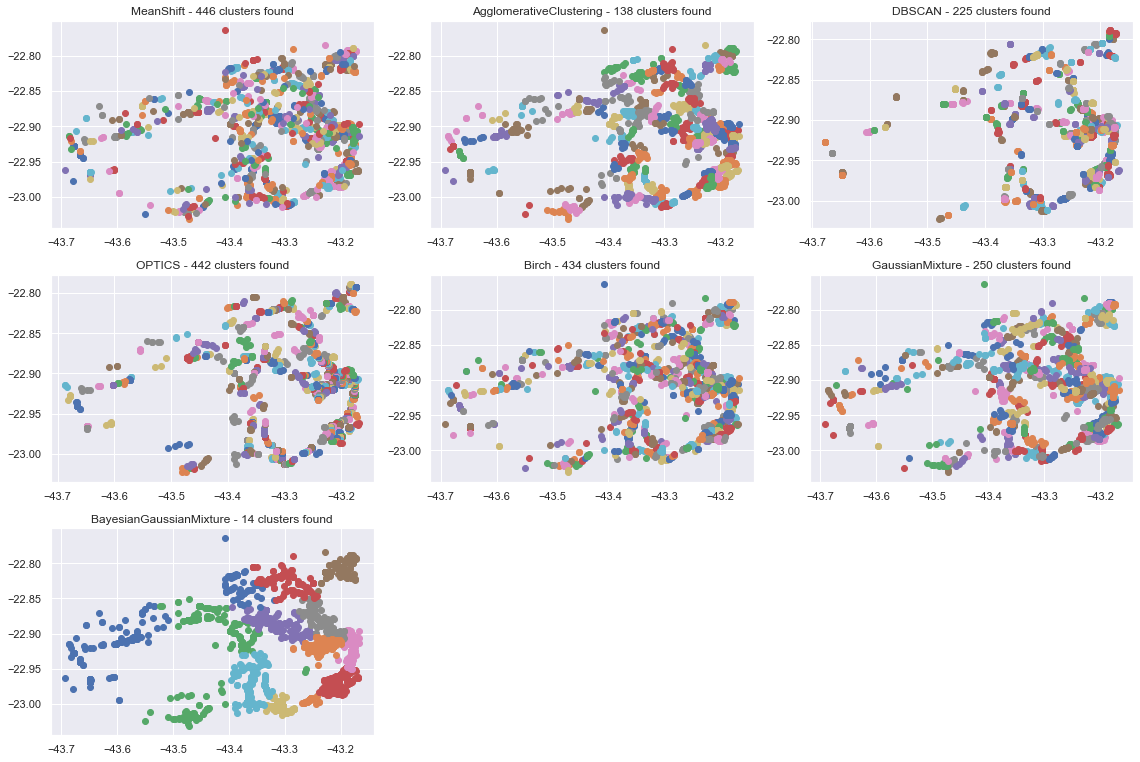

In [10]:
axs = cluster_algo_comparison(
    'EVENTO_LONGITUDE', 'EVENTO_LATITUDE',
    data, algs,
    hide_outliers=True,
    title='{} - {} clusters found',
    figsize=(16, 14), n_cols=3
)

### 3. Choose best auto algorithm - Show clusters filtered by number of samples (Paginated)

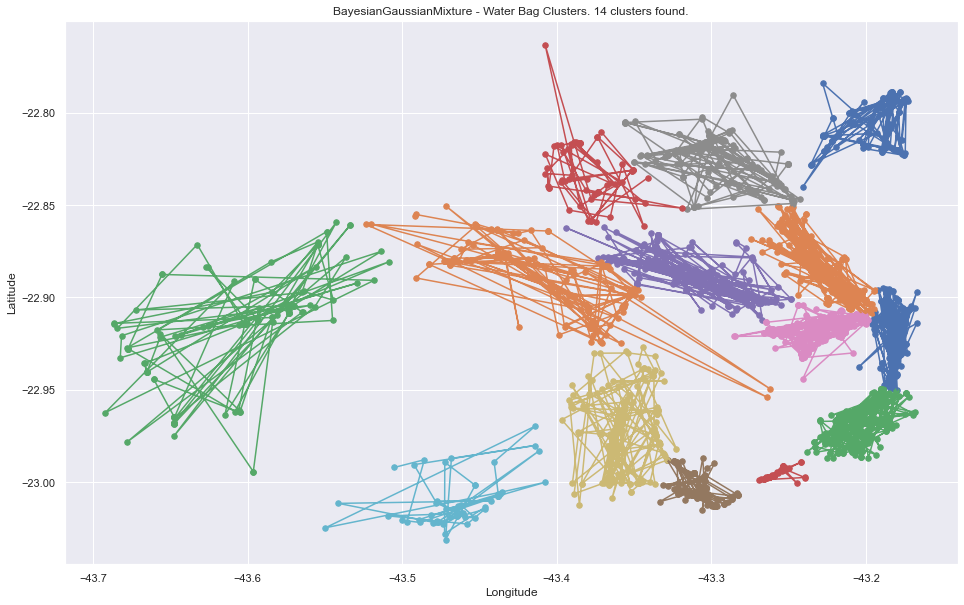

In [11]:
for sel_alg in range(len(algs)):
    data['label'] = algs[sel_alg].labels_
    in_data = data[data['label'] != -1] # Excluding outlier samples
    top_data = filter_group_size(in_data, group_col='label', min_members=10) # Excluing clusters with less then 'min_members' samples 
    
    alg_name = type(algs[sel_alg]).__name__
    connect_coordinates_colored(
        top_data['EVENTO_LONGITUDE'], top_data['EVENTO_LATITUDE'],
        top_data['label'], top_data['street_number'], cmap=None,
        title=alg_name + ' - Water Bag Clusters. {} clusters found.',
        figsize=(16, 10), connect=True
    )
    plt.show(); plt.pause(.1)
#     exit = input(f'Cluster algorithm {alg_name} ({sel_alg+1}/{len(algs)}) - Exit?') # Uncommet to enable pagination
#     if exit=='s': break
    co(wait=True)


### 4. Select choosen model

In [12]:
sel_alg = 0

data['label'] = algs[sel_alg].labels_
in_data = data[data['label'] != -1] # Excluding outlier samples
top_data = filter_group_size(in_data, group_col='label', min_members=10) # Excluing clusters with less then 'min_members' samples 

### 5. Animation: Excluding clusters by increasing minimum number of samples for choosen model

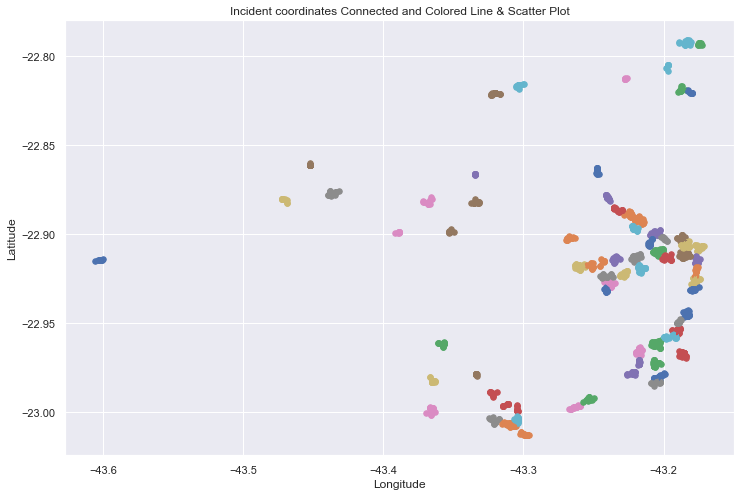

In [13]:
min_samples_clusters_animation(
    in_data, 'label',
    max_samples_stop=10, freq=1,
    figsize=(12, 8),
    connect=True
)

### 6. Save model results

Cluster info:
1. Cluster label
2. Cluster representative street
3. Cluster Centroid
4. Cluster box
5. Cluster box center
6. Cluster radius

#### Include address info and geometric properties

In [14]:
from Modules.geometric_properties import clusters_geometry

clusters = data.set_index('EVENTO_ID')[['label']]

#### Join clusters' representative routes

cluster_route_cnt = data.groupby(['label', 'route'])[['EVENTO_ID']].count().sort_values(['label', 'EVENTO_ID'], ascending=[True, False])
cluster_top_routes = cluster_route_cnt.reset_index('route').groupby('label')['route'].first().to_dict()
cluster_route_map = lambda label: cluster_top_routes[label]

clusters['main_route'] = list(map(cluster_route_map, clusters['label']))

#### Join geometric properties

geometry = clusters_geometry(
    data['EVENTO_LATITUDE'], data['EVENTO_LONGITUDE'], clusters['label'],
    include_box=True, include_center_radius=True
)

clusters = clusters.join(geometry)

#### Save clusters info

In [15]:
# clusters.to_csv('Dados/incident_clusters.csv', index=True); clusters.head(3)

---
# 3. Choosen Algorithm Result Analysis

In [16]:
top_clusters = clusters.loc[top_data['EVENTO_ID']]

#### Number of clusters with at least 'min_samples'

In [17]:
len(top_data['label'].unique())

72

### Scatter clusters in terrain map

In [18]:
areas = clusters.groupby('label').first().loc[top_data['label'].unique()]
areas['radius'] = areas['radius'] / 1000

In [19]:
import folium
from Modules.mapper import plot_markers, draw_circles, draw_rectangles

Map = folium.Map(
    location=[-22.9145, -43.2105], zoom_start=14,
    width='100%', height='100%', tiles='Stamen Terrain'
)

Map, LE = plot_markers(
    Map, top_data, radius=3,
    coord_cols=['EVENTO_LATITUDE', 'EVENTO_LONGITUDE'],
    group_col='label', cmap='tab20',
    exclude=[], touch_coord=True, return_encoder=True
)

# Map = draw_circles(
#     Map, areas,
#     loc=['lat_center', 'lng_center'], radius='radius',
#     popup='main_route', tooltip='main_route',
#     cmap='tab20', lut=len(areas), LE=LE,
#     stroke=True, weight=4, fill=True,
#     fill_color=None, fill_opacity=.3
# )

Map = draw_rectangles(
    Map, areas,
    loc=[['lat_min', 'lng_min'], ['lat_max', 'lng_max']],
    popup='main_route', tooltip='main_route',
    cmap='tab20', lut=len(areas), LE=LE,
    stroke=True, weight=3, fill=True,
    fill_color=None, fill_opacity=.3
)

Map

### Samples per cluster

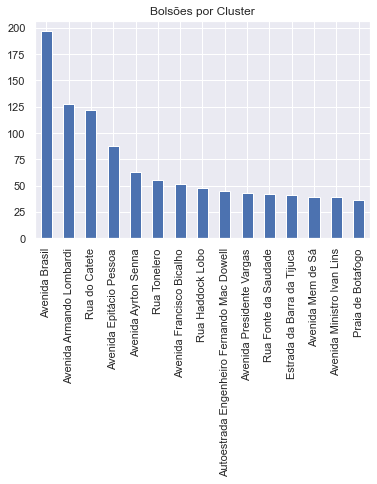

In [20]:
ax = top_clusters['main_route'].value_counts().head(15).plot.bar(title='Bolsões por Cluster'); plt.show()

### Routes per cluster distribution

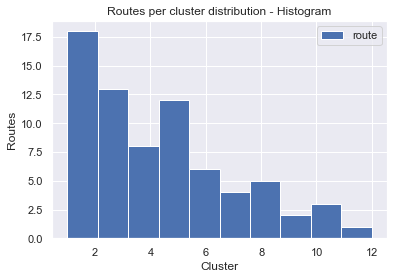

In [21]:
ax = top_data.groupby(['label'])[['route']].nunique().sort_values('route', ascending=False).plot.hist()
ax.set(title='Routes per cluster distribution - Histogram', ylabel='Routes', xlabel='Cluster')
plt.show()

### Cluster radius statistical description

In [22]:
(top_clusters[['radius']]).describe()

,radius
count,1850.000000
mean,305.259706
std,106.351591
min,44.202728
25%,222.436550
50%,307.824791
75%,374.484602
max,511.504778
